<a href="https://colab.research.google.com/github/gpdsec/Residual-Neural-Network/blob/main/Custom_Resnet_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*It's custom ResNet trained demonstration purpose, not for accuracy.
Dataset used is cats_vs_dogs dataset from tensorflow_dataset with **Custom Augmentatior** for data augmentation*

---


In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **1. Importing Libraries**





In [27]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Input, GlobalMaxPooling2D, add, ReLU
from tensorflow.keras import layers
from tensorflow.keras import Sequential
import tensorflow_datasets as tfds
import pandas as pd
import numpy as np
from tensorflow.keras import Model
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from PIL import Image
from tqdm.notebook import tqdm
import os
import time
%matplotlib inline


### **2. Loading & Processing Data**





##### **Loading Data**

In [28]:
(train_ds, val_ds, test_ds), info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True)


In [29]:
## Image preprocessing function
def preprocess(img, lbl):
    image = tf.image.resize_with_pad(img, target_height=224, target_width=224)
    image = tf.divide(image, 255)
    label = [0,0]
    if int(lbl) == 1:
      label[1]=1
    else:
      label[0]=1
    return image, tf.cast(label, tf.float32)

In [30]:
train_ds = train_ds.map(preprocess)
test_ds = test_ds.map(preprocess)
val_ds = val_ds.map(preprocess)


In [31]:
info

tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    version=4.0.0,
    description='A large set of images of cats and dogs.There are 1738 corrupted images that are dropped.',
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=54765',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=23262,
    splits={
        'train': 23262,
    },
    supervised_keys=('image', 'label'),
    citation="""@Inproceedings (Conference){asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorization,
    author = {Elson, Jeremy and Douceur, John (JD) and Howell, Jon and Saul, Jared},
    title = {Asirra: A CAPTCHA that Exploits Interest-Aligned Manual Image Categorization},
    booktitle = {Proceedings of 14th ACM Conference on Computer and Communications Security (CCS)},
    ye

####  **Data Augmentation layer**





In [32]:
###### Important Variables

batch_size = 32
shape = (224, 224, 3)
training_steps = int(18610/batch_size)
validation_steps = int(2326/batch_size)
path = '/content/drive/MyDrive/Colab Notebooks/cats_v_dogs.h5'  

In [33]:
#######  Data agumentation layer
# RandomFlip and RandomRotation Suits my need for Data Agumentation


augmentation=Sequential([
              layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
              layers.experimental.preprocessing.RandomRotation(0.2),
              ])

####### Data Shuffle and batch Function
def shufle_batch(train_set, val_set, batch_size): 
    train_set=(train_set.shuffle(1000).batch(batch_size))
    train_set = train_set.map(lambda x, y: (augmentation(x, training=True), y))
    val_set = (val_set.shuffle(1000).batch(batch_size))
    val_set = val_set.map(lambda x, y: (augmentation(x, training=True), y))
    return train_set, val_set


train_set, val_set  = shufle_batch(train_ds, val_ds, batch_size)


## **3. Creating Model**

##### **Creating Residual block**

In [34]:
def residual_block(x, feature_map, filter=(3,3) , _strides=(1,1), _network_shortcut=False):
    shortcut = x
    x = Conv2D(feature_map, filter, strides=_strides, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    x = Conv2D(feature_map, filter, strides=_strides, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    
    if _network_shortcut :
        shortcut = Conv2D(feature_map, filter, strides=_strides, activation='relu', padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    x = add([shortcut, x])
    x = ReLU()(x)

    return x

In [35]:
# Build the model using the functional API
i = Input(shape)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(i)
x = BatchNormalization()(x)
x = residual_block(x, 32, filter=(3,3) , _strides=(1,1), _network_shortcut=False)
#x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
#x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = residual_block(x,64, filter=(3,3) , _strides=(1,1), _network_shortcut=False)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dropout(0.2)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(2, activation='sigmoid')(x)

model = Model(i, x)

In [36]:
model.compile()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 224, 224, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 32) 9248        batch_normalization[0][0]        
______________________________________________________________________________________________

### **4. Optimizer and loss Function** 

In [37]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=False)
Optimiser = tf.keras.optimizers.Adam()

### **5. Metrics For Loss and Acuracy**

In [38]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.BinaryAccuracy(name='train_accuracy')
test_loss = tf.keras.metrics.Mean(name="test_loss")
test_accuracy = tf.keras.metrics.BinaryAccuracy(name='test_accuracy')

### **6. Function for training and Testing**

In [39]:
@tf.function
def train_step(images, labels):
  with tf.GradientTape() as tape:
    prediction = model(images, training=True)
    loss = loss_object(labels,prediction)
  gradient = tape.gradient(loss, model.trainable_variables)
  Optimiser.apply_gradients(zip(gradient, model.trainable_variables))
  train_loss(loss)
  train_accuracy(labels, prediction)

In [40]:
@tf.function
def test_step(images, labels):
  prediction = model(images, training = False)
  t_loss = loss_object(labels, prediction)
  test_loss(t_loss)
  test_accuracy(labels, prediction)

### **7. Training Model**

In [41]:
EPOCHS = 25
Train_LOSS = []
TRain_Accuracy = []
Test_LOSS = []
Test_Accuracy = [] 

for epoch in range(EPOCHS):
  train_loss.reset_states()
  train_accuracy.reset_states()
  test_loss.reset_states()
  test_accuracy.reset_states()
  print(f'Epoch : {epoch+1}')

  count = 0  # variable to keep tab how much data steps of training
  desc = "EPOCHS {:0>4d}".format(epoch+1)


  for images, labels in tqdm(train_set, total=training_steps, desc=desc):
    train_step(images, labels)
  
  for test_images, test_labels in val_set:
    test_step(test_images, test_labels)
 
    
    
  

  print(
      f'Loss: {train_loss.result()}, '
      f'Accuracy: {train_accuracy.result()*100}, '
      f'Test Loss: {test_loss.result()}, '
      f'Test Accuracy: {test_accuracy.result()*100}'
  )

  Train_LOSS.append(train_loss.result())
  TRain_Accuracy.append(train_accuracy.result()*100)
  Test_LOSS.append(test_loss.result())
  Test_Accuracy.append(test_accuracy.result()*100)

  ### Saving BestModel

  if epoch==0:
    min_Loss = test_loss.result()
    min_Accuracy = test_accuracy.result()*100
  elif (min_Loss>test_loss.result()):
    if (min_Accuracy <= test_accuracy.result()*100) :
      min_Loss = test_loss.result()
      min_Accuracy = ( test_accuracy.result()*100)
      print(f"Saving Best Model {epoch+1}")
      model.save_weights(path)                            # Saving Model To drive
      

Epoch : 1



Loss: 0.8951160907745361, Accuracy: 60.71466827392578, Test Loss: 0.6144601106643677, Test Accuracy: 66.05760955810547
Epoch : 2



Loss: 0.5782817006111145, Accuracy: 70.3358383178711, Test Loss: 0.5655090808868408, Test Accuracy: 71.15219116210938
Saving Best Model 2
Epoch : 3



Loss: 0.5373100638389587, Accuracy: 73.79366302490234, Test Loss: 0.607060432434082, Test Accuracy: 68.14273834228516
Epoch : 4



Loss: 0.4930744469165802, Accuracy: 77.34820556640625, Test Loss: 0.7114728093147278, Test Accuracy: 65.24076080322266
Epoch : 5



Loss: 0.46205979585647583, Accuracy: 78.72380828857422, Test Loss: 0.6633371710777283, Test Accuracy: 66.3370590209961
Epoch : 6



Loss: 0.43398579955101013, Accuracy: 80.91617584228516, Test Loss: 1.0116767883300781, Test Accuracy: 56.4918327331543
Epoch : 7



Loss: 0.39585351943969727, Accuracy: 83.03600311279297, Test Loss: 0.4717559814453125, Test Accuracy: 78.28890991210938
Saving Best Model 7
Epoch : 8



Loss: 0.3688928782939911, Accuracy: 84.37936401367188, Test Loss: 0.3947010636329651, Test Accuracy: 81.40584564208984
Saving Best Model 8
Epoch : 9



Loss: 0.34516939520835876, Accuracy: 85.39225769042969, Test Loss: 0.3787277042865753, Test Accuracy: 81.98624420166016
Saving Best Model 9
Epoch : 10



Loss: 0.3237535059452057, Accuracy: 86.4374008178711, Test Loss: 0.3299771249294281, Test Accuracy: 86.09200286865234
Saving Best Model 10
Epoch : 11



Loss: 0.2972607910633087, Accuracy: 87.57119750976562, Test Loss: 0.35069704055786133, Test Accuracy: 84.60877227783203
Epoch : 12



Loss: 0.27937743067741394, Accuracy: 88.54379272460938, Test Loss: 0.4506056308746338, Test Accuracy: 80.54600524902344
Epoch : 13



Loss: 0.26411622762680054, Accuracy: 89.1778564453125, Test Loss: 0.2971752882003784, Test Accuracy: 87.51074981689453
Saving Best Model 13
Epoch : 14



Loss: 0.24262875318527222, Accuracy: 90.5131607055664, Test Loss: 0.25758856534957886, Test Accuracy: 88.54256439208984
Saving Best Model 14
Epoch : 15



Loss: 0.23708689212799072, Accuracy: 90.542724609375, Test Loss: 0.23830978572368622, Test Accuracy: 89.61737060546875
Saving Best Model 15
Epoch : 16



Loss: 0.2278800755739212, Accuracy: 91.04782104492188, Test Loss: 0.27509236335754395, Test Accuracy: 87.94066619873047
Epoch : 17



Loss: 0.2137322872877121, Accuracy: 91.52874755859375, Test Loss: 0.2565723955631256, Test Accuracy: 90.5846939086914
Epoch : 18



Loss: 0.2027980536222458, Accuracy: 91.9398193359375, Test Loss: 0.2630709111690521, Test Accuracy: 88.71453094482422
Epoch : 19



Loss: 0.19818884134292603, Accuracy: 92.32402038574219, Test Loss: 0.21125762164592743, Test Accuracy: 91.44454193115234
Saving Best Model 19
Epoch : 20



Loss: 0.1873503178358078, Accuracy: 92.66255187988281, Test Loss: 0.2645404040813446, Test Accuracy: 89.03697204589844
Epoch : 21



Loss: 0.18707913160324097, Accuracy: 92.7162857055664, Test Loss: 0.24838000535964966, Test Accuracy: 88.8864974975586
Epoch : 22



Loss: 0.17572899162769318, Accuracy: 93.0574951171875, Test Loss: 0.25656965374946594, Test Accuracy: 89.48839569091797
Epoch : 23



Loss: 0.16926749050617218, Accuracy: 93.47662353515625, Test Loss: 0.1912163347005844, Test Accuracy: 92.56233978271484
Saving Best Model 23
Epoch : 24



Loss: 0.16717669367790222, Accuracy: 93.3799057006836, Test Loss: 0.24589204788208008, Test Accuracy: 89.44540405273438
Epoch : 25



Loss: 0.167562797665596, Accuracy: 93.41483306884766, Test Loss: 0.18339981138706207, Test Accuracy: 93.01375579833984
Saving Best Model 25


### **8. Ploting Loss and Accuracy Per Iteration**

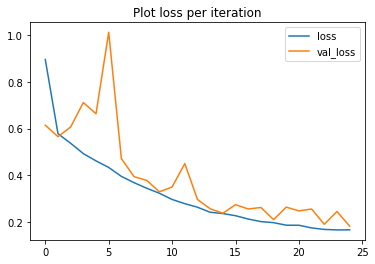

In [42]:
# Plot loss per iteration
plt.plot(Train_LOSS, label='loss')
plt.plot(Test_LOSS, label='val_loss')
plt.title('Plot loss per iteration')
plt.legend()

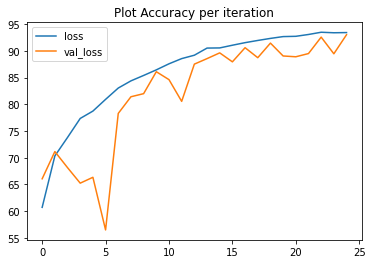

In [43]:
# Plot Accuracy per iteration
plt.plot(TRain_Accuracy, label='loss')
plt.plot(Test_Accuracy, label='val_loss')
plt.title('Plot Accuracy per iteration')
plt.legend()

## 9. Evoluting model

##### **Note-**
Testing Accuracy of Model with Complete Unseen DataSet.

In [44]:
model.load_weights(path)

In [45]:
len(test_ds)

2326

In [46]:
test_set = test_ds.shuffle(50).batch(2326)

In [47]:
for images, labels in test_set:
  prediction = model.predict(images)
  break
## Function For Accuracy
def accuracy(prediction, labels):
    corect =0
    for i in range(len(prediction)):
      pred = prediction[i]
      labe = labels[i]
      if pred[0]>pred[1] and labe[0]>labe[1]:
        corect+=1
      elif pred[0]<pred[1] and labe[0]<labe[1]:
        corect+=1
    
    return (corect/len(prediction))*100
 

In [48]:
print(accuracy(prediction, labels))


93.50816852966466
